# Overview

This competition is a joint initiative by Planet and SCCON, showcasing how satellite imagery can be leveraged to monitor deforestation and climate change overtime. In this challenge, we need to design a multilabel classifier to help detect both small and large scale interventionism within the Amazon forest.

The stakes of this project are paramount to share knowledge on computer vision applied to forestry and generalize these techniques to other forest monitoring use-cases. Datasets and AI projects on forests are still scarced, so there is a growing need to create massive catalog and gather intelligence about biodiversity. Ultimately, it will benefits and attract more company like [Pachama](https://pachama.com) or [Avalanche](https://avalanche.green/) to protect and get a deeper understanding of our forests.

The quantity of labelized images in this challenge is limited (about 40,000), so we need to retrain existing models on this small Planet dataset. Resnet has shown to be a strong candidate on previous challenges among pretrained models like VGG, Inception and DenseNet (full list of pretrained torchvision models [here](https://pytorch.org/vision/stable/models.html)). New deep learning techniques are emerging and ideas worth exploring include the following:
- [Cossim CNN](https://www.rpisoni.dev/posts/cossim-convolution/)
- [Vision Transformers](https://github.com/lucidrains/vit-pytorch)
- [Self-supervised learning](https://docs.lightly.ai/tutorials/package/tutorial_simsiam_esa.html)

This dataset initially contained 4 bands satellite imagery —R, G, B and Near-Infrared (NIR)—, available through torrent download. The torrents seem to have been disabled but fortunately, a Kaggler have saved [the entire RGB .png dataset](https://www.kaggle.com/nikitarom/planets-dataset). The .tif files containing the NIR dataset however, aren't available anymore. NIR is especially useful to compute greenness indexes such as the NDVI. It allows a finer visualisation of the tree canopee and measurement of the carbon absorption, although we would need to recreate a model from scratch to use it, since all models have been pretrained on RGB only. 

The dataset contains a wide class imbalance, with primary forest presence on more than 90% of the labels, whereas conventional mining only account for 0.25%. We need to monitor the scores for these rare classes, as they are the key to an overall good score and an efficient model to detect ponctual human activity.

## Packages and setup

In [1]:
import os
import random
from time import time
from glob import glob
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from collections import Counter
import dill as pickle

from plotly import graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

from matplotlib import pyplot as plt
%matplotlib inline

import cv2

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import fbeta_score, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T, models
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
!pip install -q torchsummary --user
from torchsummary import summary


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


device: cuda


We set random seeding for reproducibility purposes.

In [2]:
random.seed(101)
np.random.seed(101)
torch.manual_seed(101);

In [3]:
!ls ../input/planets-dataset/planet/planet

sample_submission.csv  test-jpg  train-jpg  train_classes.csv


# Data Exploration

### Labels distribution

Let's first load the training dataset and quantify the label distributions.

In [4]:
path = "../input/planets-dataset/planet/planet/"
path_train = os.path.join(path, "train-jpg")
path_test = os.path.join(path, "test-jpg")
print(
    f"train files: {len(os.listdir(path_train))}, "
    f"test files: {len(os.listdir(path_test))}"
)

train files: 40479, test files: 40669


In [5]:
path_class = os.path.join(path, "train_classes.csv")
df_class = pd.read_csv(path_class)
print(df_class.shape)
df_class.head()

(40479, 2)


image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road

Simple counter of individual label, by splitting them from tags.

In [6]:
df_class["list_tags"] = df_class.tags.str.split(" ")
row_tags = df_class.list_tags.values
tags = [tag for row in row_tags for tag in row]
counter_tags = Counter(tags)
df_tags = pd.DataFrame(
    {"tag": counter_tags.keys(), "total": counter_tags.values()}
).sort_values("total")

fig = px.bar(df_tags, x="total", y="tag", orientation="h", 
             color="total",
)
fig.update_layout(title="Class distribution")
fig.show()

As expected, some classes are largely representated whereas some are barely present in this dataset, in a Pareto distribution fashion.
There is an important risk that our model barely learn the rare classes or even to exclude them from the training data upon splitting between training and validating sets.
We identify clearly theses classes for latter investigation.

In [7]:
RARE_CLASSES = [
    "bare_ground", "selective_logging", "artisinal_mine", "blooming", "slash_burn", "blow_down", "conventional_mine"
]

### Class visualisation

Let's now observe each label invidually. Each image is mapped to a list of labels, with a total of 17 different labels.
All 17 labels are "almost" independant, meaning that `primary` can be found along with `slash burn`. I said "almost" because `cloudy` affects visibility, so that no other label can be found in the same image.

For sake of clarity, I only displayed one label per image on the figure below. When images are associated to multiple labels, I displayed them multiple times (e.g. `primary` and `haze`).

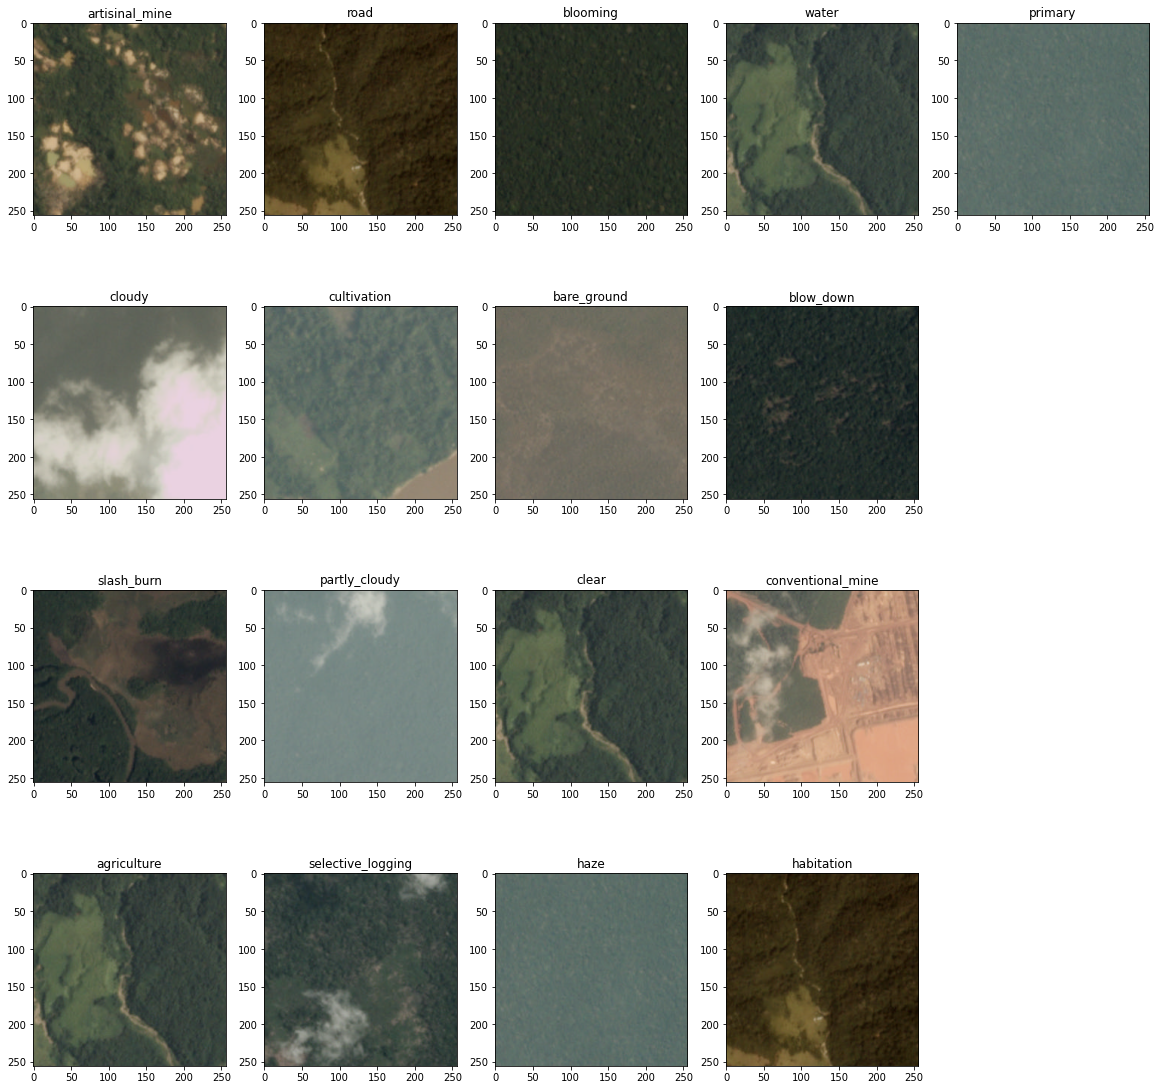

In [8]:
all_tags = list(set(tags))
N_tags = len(all_tags)
fig, axes = plt.subplots(4, (N_tags//4)+1, figsize=(20, 20))
for idx, tag in enumerate(all_tags):
    filename = df_class.loc[df_class.tags.str.contains(tag)].image_name.values[0]
    img = cv2.imread(os.path.join(path_train, filename+".jpg"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    idx_col = idx // 4
    idx_row = idx % 4
    axes[idx_row][idx_col].set_title(tag)
    axes[idx_row][idx_col].imshow(img)
axes[1][-1].remove()
axes[2][-1].remove()
axes[3][-1].remove()

We can make few remarks here:
- Some labels like "water" or "road" are challenging to differenciate
- Some rare labels like selecting logging and blooming are also hard to discriminate, and are barely visible at all
- Strong correlations can be expected between labels like habitation, road and cultivations

### T-SNE and dimension shrinking for visualisation

T-SNE allows us to cluster our dataset by shrinking the image dimensions to only 2. It is useful for a quick visualisation of our dataset.

Scikit-learn documentation:
> <i>T-distributed Stochastic Neighbor Embedding</i>.
>
> <i>t-SNE [1] is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.</i>

We need to convert each image to a normalized 1D vector that we can stake onto each other. This matrix will be the input of our TSNE.

In [9]:
def load_img(path_file):
    img = cv2.imread(path_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (100, 100), cv2.INTER_LINEAR).astype(float)
    img = cv2.normalize(img, None, 0.0, 1.0, cv2.NORM_MINMAX)
    img = img.reshape(1, -1)
    return img

We only sample 600 images as an estimation of our dataset diversity.

In [10]:
filenames = df_class.image_name.sample(600).values
path_files = [os.path.join(path_train, filename+".jpg") for filename in filenames]
X_train_sample = np.vstack([load_img(path_file) for path_file in path_files])
X_train_sample.shape

(600, 30000)

In [11]:
tsne = TSNE(
    n_components=2,
    init="random",
    random_state=101,
    method="barnes_hut",
    n_iter=500,
    verbose=2,
)
X_embedded = tsne.fit_transform(X_train_sample)
X_embedded.shape

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 600 samples in 1.027s...
[t-SNE] Computed neighbors for 600 samples in 22.461s...
[t-SNE] Computed conditional probabilities for sample 600 / 600
[t-SNE] Mean sigma: 6.345056
[t-SNE] Computed conditional probabilities in 0.031s
[t-SNE] Iteration 50: error = 76.9434052, gradient norm = 0.3875073 (50 iterations in 0.222s)
[t-SNE] Iteration 100: error = 78.8464813, gradient norm = 0.3610037 (50 iterations in 0.233s)
[t-SNE] Iteration 150: error = 80.2214203, gradient norm = 0.3752887 (50 iterations in 0.244s)
[t-SNE] Iteration 200: error = 79.5382156, gradient norm = 0.3439538 (50 iterations in 0.235s)
[t-SNE] Iteration 250: error = 78.5301743, gradient norm = 0.3924351 (50 iterations in 0.259s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.530174
[t-SNE] Iteration 300: error = 1.1853877, gradient norm = 0.0063058 (50 iterations in 0.271s)
[t-SNE] Iteration 350: error = 0.9817696, gradient norm = 0.0045863 

(600, 2)

In [12]:
def fetch_img(path_file, h, w):
    img = cv2.imread(path_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (h*2, w*2), cv2.INTER_LINEAR)
    return img

Now that we have the embedding matrix (i.e. `x` and `y` for each image in the 2D space output), we just have to draw a white canva, and place pictures according to their embedding on it. We also need to rescale them based on the canva dimensions.

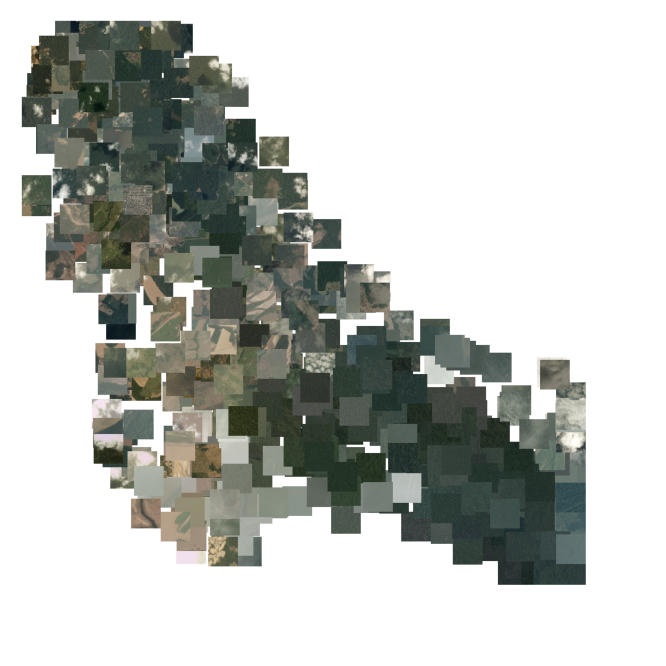

In [13]:
size_img = 1000
offset_img = 50
h = w = int(offset_img / 2)

X_scaled = (X_embedded - X_embedded.min(0)) / (X_embedded.max(0) - X_embedded.min(0))
X_scaled = (X_scaled * size_img).astype(int)
X_scaled = np.clip(X_scaled, offset_img, size_img-offset_img)

img_tsne = np.ones((size_img+2*offset_img, size_img+2*offset_img, 3), dtype=np.uint8) * 255
for idx in range(X_scaled.shape[0]):
    x, y = X_scaled[idx][0], X_scaled[idx][1]
    img = fetch_img(path_files[idx], h, w)
    img_tsne[x-w:x+w, y-h:y+h, :] = img

fig = plt.figure(figsize=(12, 12))
plt.imshow(img_tsne);
plt.axis("off");

# Model training

### Transformations

For optimal performances, [resnet18 need input shape that are multiple of 32](https://discuss.pytorch.org/t/input-image-shape-for-resnet18-architecture/80693) and in our case we have input of size 256. From 256, the closest multiple of 32 is 224.

Therefore, we rescale our input data using this multiple, and we also normalize our dataset based on resnet pretrained mean and standard deviation intensity values. `ToTensor()` is useful to normalize our image values from 0-255 range to 0-1 range.

In [14]:
def get_transforms():
    transform_train = T.Compose([
      T.ToPILImage(),
      T.Resize(224),
      T.ToTensor(),
      T.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225],
      )
    ])
    transform_val = T.Compose([
      T.ToPILImage(),
      T.Resize(224),
      T.ToTensor(),
      T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
      )
    ])
    return transform_train, transform_val

We define our custom Dataset class to manipulate batches of data between RAM and Disk more easily. Some point of attentions:
- `__init__`: we pass the dataframe along with the target, the transformation, the file path and `is_train` flag. It is important to distinguish the training phase from the testing phase because we use test augmentation. <br> Test augmentation (TTA) is helpful to diversify our training dataset and build a more robust model. It is applied on each image for each batch, meaning that is doesn't increase the length of our training dataset per say, but it transforms each image randomly during execution time.
- `__getitem__`: we define what the dataset return upon iteration. It needs to load both image and target.
- `collate_fn`: we use this function within the following DataLoader instance. It corresponds to the batch manipulation. This is were `transform` is called. We also proceed to train and test augmentation there.

In [15]:
class AmazonDatasetError(Exception):
    pass


class AmazonDataset(Dataset):
    def __init__(self, df, ohe_tags, transform, path, is_train=True, idx_tta=None):
        super().__init__()
        self.df = df
        self.ohe_tags = ohe_tags
        self.transform = transform
        if isinstance(path, str):
            self.paths = [path]
        elif isinstance(path, (list, tuple)):
            self.paths = path
        else:
            raise AmazonDatasetError(f"Path type must be str, list or tuple, got: {type(path)}")
        self.is_train = is_train
        if not is_train:
            if not idx_tta in list(range(6)):
                raise AmazonDatasetError(
                    f"In test mode, 'idx_tta' must be an int belonging to [0, 5], got: {repr(idx_tta)}"
                )
            self.idx_tta = idx_tta

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = self.df.iloc[idx].image_name + ".jpg"
        for path in self.paths:
            if filename in os.listdir(path):
                file_path = os.path.join(path, filename)
                break
        else:
            raise AmazonDatasetError(f"Can't fetch {filename} among {self.paths}")
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.ohe_tags[idx]
        return img, label

    def collate_fn(self, batch):
        imgs, labels = [], []
        for (img, label) in batch:
            img = self.custom_augment(img)
            img = torch.tensor(img)
            img = img.permute(2, 0, 1)
            img = self.transform(img)
            imgs.append(img[None])
            labels.append(label)
        imgs = torch.cat(imgs).float().to(device)
        labels = torch.tensor(labels).float().to(device)
        return imgs, labels

    def load_img(self, idx, ax=None):
        img, ohe_label = self[idx]
        label = self.df.iloc[idx].tags
        title = f"{label} - {ohe_label}"
        if ax is None:
            plt.imshow(img)
            plt.title(title)
        else:
            ax.imshow(img)
            ax.set_title(title)
    
    def custom_augment(self, img):
        """
        Discrete rotation and horizontal flip.
        Random during training and non random during testing for TTA.
        Not implemented in torchvision.transforms, hence this function.
        """
        choice = np.random.randint(0, 6) if self.is_train else self.idx_tta
        if choice == 0:
            # Rotate 90
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_90_CLOCKWISE)
        if choice == 1:
            # Rotate 90 and flip horizontally
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_90_CLOCKWISE)
            img = cv2.flip(img, flipCode=1)
        if choice == 2:
            # Rotate 180
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_180)
        if choice == 3:
            # Rotate 180 and flip horizontally
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_180)
            img = cv2.flip(img, flipCode=1)
        if choice == 4:
            # Rotate 90 counter-clockwise
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_90_COUNTERCLOCKWISE)
        if choice == 5:
            # Rotate 90 counter-clockwise and flip horizontally
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_90_COUNTERCLOCKWISE)
            img = cv2.flip(img, flipCode=1)
        return img

We are now ready for all full data pipeline! We define our target encoder first before, wrapping our custom train and validation dataset within `DataLoaders`, with a batch size of 64 —a good trade-off between RAM usage and speed in our case.

In [16]:
def get_data(df_train, df_val):

    encoder = MultiLabelBinarizer()
    ohe_tags_train = encoder.fit_transform(df_train.list_tags.values)
    ohe_tags_val = encoder.transform(df_val.list_tags.values)

    transform_train, transform_val = get_transforms()
    ds_train = AmazonDataset(df_train, ohe_tags_train, transform_train, path=path_train)
    ds_val = AmazonDataset(df_val, ohe_tags_val, transform_val, path=path_train)

    dl_train = DataLoader(
      ds_train,
      batch_size=64,
      shuffle=True,
      collate_fn=ds_train.collate_fn
    )
    dl_val = DataLoader(
      ds_val,
      batch_size=64,
      shuffle=True,
      collate_fn=ds_val.collate_fn
    )

    return ds_train, ds_val, dl_train, dl_val, encoder

Sanity check: we expect `imgs` to be a batch of our chosen batch size (64), with 3 channels and of chosen image dimensions (224x224). <br>
`labels` are also a batch of our chosen size (64) with 17 different classes.

In [17]:
df_train, df_val = train_test_split(df_class, test_size=.2)

ds_train, ds_val, dl_train, dl_val, encoder = get_data(df_train, df_val)

imgs, labels = next(iter(dl_train))
imgs.shape, labels.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64, 17]))

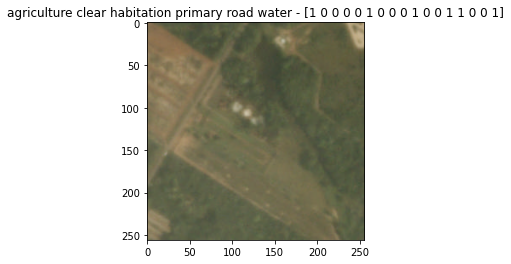

In [18]:
ds_train.load_img(5)

### Model definition

We download directly weights from the pretrained resnet18, and freeze all weights. We overwrite the last fully connected layer, by adding two dense layers followed by a sigmoid. This `fc` last part is the only layer to be trained.

In [19]:
def get_model():
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.require_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    model.fc = nn.Sequential(
      nn.Flatten(),
      nn.Linear(512, 128), # 512 for resnet18 or 2048 for resnet 50
      nn.ReLU(inplace=True),
      nn.Dropout(.2),
      nn.Linear(128, 17),
      nn.Sigmoid()
    )
    optimizer = Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.BCELoss()

    return model.to(device), optimizer, loss_fn

## Training

In [20]:
def train_batch(X, Y, model, loss_fn, optimizer):
    model.train()
    optimizer.zero_grad()
    Y_hat = model(X)
    batch_loss = loss_fn(Y_hat, Y)
    batch_loss.backward()
    optimizer.step()
    Y_hat = Y_hat.detach().float().cpu().numpy()
    
    return Y_hat, batch_loss.item()


@torch.no_grad()
def compute_val_loss(X, Y, model, loss_fn):
    model.eval()
    Y_hat = model(X)
    batch_loss = loss_fn(Y_hat, Y)
    Y_hat = Y_hat.detach().float().cpu().numpy()
    
    return Y_hat, batch_loss.item()

We choose to train our model for 21 epochs, while decreasing our learning rate by 10x every 7 batches. We monitor the validation loss are our key metrics. The validation score is just useful as side indication, because we choose the classification threshold quite randomly (0.2). <br>
Later on, we will find the most adapted threshold for each target.

In [21]:
def train_model(dl_train, dl_val, idx_fold):
    model, optimizer, loss_fn = get_model()
    lr_scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

    loss_train, loss_val = [], []
    score_train, score_val = [], []

    Y_hat_val = None
    best_loss_val = np.inf

    epochs = 14
    for idx in range(epochs):
        loss_train_epoch, loss_val_epoch = [], []
        Y_hat_train_epoch, Y_hat_val_epoch = [], []
        Y_train_epoch, Y_val_epoch = [], []

        for X, Y in tqdm(dl_train, leave=False):
            Y_hat, batch_loss = train_batch(X, Y, model, loss_fn, optimizer)
            loss_train_epoch.append(batch_loss)
            Y_hat_train_epoch.extend(Y_hat)
            Y_train_epoch.extend(Y.detach().float().cpu().numpy())

        for X, Y in tqdm(dl_val, leave=False):
            Y_hat, batch_loss = compute_val_loss(X, Y, model, loss_fn)
            loss_val_epoch.append(batch_loss)
            Y_hat_val_epoch.extend(Y_hat)
            Y_val_epoch.extend(Y.detach().float().cpu().numpy())
                
        avg_loss_train = np.mean(loss_train_epoch)
        avg_loss_val = np.mean(loss_val_epoch)

        Y_hat_train_epoch = np.array(Y_hat_train_epoch)
        Y_hat_val_epoch = np.array(Y_hat_val_epoch)
        Y_thresh_train_epoch = (Y_hat_train_epoch > .2).astype(float)
        Y_thresh_val_epoch = (Y_hat_val_epoch > .2).astype(float)
        Y_train_epoch = np.array(Y_train_epoch)
        Y_val_epoch = np.array(Y_val_epoch)
        
        score_train_epoch = fbeta_score(Y_train_epoch, Y_thresh_train_epoch, beta=2, average="samples")
        score_val_epoch = fbeta_score(Y_val_epoch, Y_thresh_val_epoch, beta=2, average="samples")
               
        # saving values for debugging
        if avg_loss_val < best_loss_val:
            best_loss_val = avg_loss_val
            Y_hat_val = Y_hat_val_epoch
            Y_thresh_val = Y_thresh_val_epoch
            Y_val = Y_val_epoch
            
        loss_train.append(avg_loss_train)
        loss_val.append(avg_loss_val)
        score_train.append(score_train_epoch)
        score_val.append(score_val_epoch)

        print(
            f"epoch: {idx}/{epochs} -- train loss: {avg_loss_train}, " \
            f"val loss: {avg_loss_val}" \
            f" -- train fbeta_score: {score_train_epoch}, " \
            f"val fbeta_score: {score_val_epoch}"
        )
        
        lr_scheduler.step()

    train_results = {
        "loss_train": loss_train,
        "loss_val": loss_val,
        "score_train": score_train,
        "score_val": score_val,
        "Y_hat_val": Y_hat_val,
        "Y_thresh_val": Y_thresh_val,
        "Y_val": Y_val,
    }
        
    torch.save(model, f"resnet18_fold{idx_fold}.pth")
    pickle.dump(train_results, open(f"train_results_fold{idx_fold}.pkl", "wb"))

There is a risk that we have created an imbalance within our rare classes, by splitting randomly our dataset between train and validation. Let's ensure that rare classes representation are similar between both datasets.

In [22]:
for rare_class in RARE_CLASSES:
    total_train = df_train.loc[df_train.tags.str.contains(rare_class)].shape[0]
    total_val = df_val.loc[df_val.tags.str.contains(rare_class)].shape[0]
    print(f"train {rare_class}: {100 * total_train / df_train.shape[0]:.4f}% ({total_train})")
    print(f"val {rare_class}: {100 * total_val / df_val.shape[0]:.4f}% ({total_val})\n")

train bare_ground: 2.1709% (703)
val bare_ground: 1.9639% (159)

train selective_logging: 0.8523% (276)
val selective_logging: 0.7905% (64)

train artisinal_mine: 0.8214% (266)
val artisinal_mine: 0.9017% (73)

train blooming: 0.7844% (254)
val blooming: 0.9634% (78)

train slash_burn: 0.4941% (160)
val slash_burn: 0.6052% (49)

train blow_down: 0.2470% (80)
val blow_down: 0.2223% (18)

train conventional_mine: 0.2470% (80)
val conventional_mine: 0.2470% (20)



In [23]:
train_model(dl_train, dl_val, 0)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

epoch: 0/14 -- train loss: 0.15391719977375076, val loss: 0.09873347295316186 -- train fbeta_score: 0.8616375958515873, val fbeta_score: 0.9168350081606544


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

epoch: 1/14 -- train loss: 0.10238756826920471, val loss: 0.09420353505672432 -- train fbeta_score: 0.9111371065296278, val fbeta_score: 0.9167020768334895


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

epoch: 2/14 -- train loss: 0.0956558164636137, val loss: 0.09038537338845373 -- train fbeta_score: 0.9178174364429182, val fbeta_score: 0.9218698859772472


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

epoch: 3/14 -- train loss: 0.09052950317562804, val loss: 0.09247326311164016 -- train fbeta_score: 0.9217404585337449, val fbeta_score: 0.919679565472646


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

epoch: 4/14 -- train loss: 0.08749675480538442, val loss: 0.08887078064515835 -- train fbeta_score: 0.9247787100081405, val fbeta_score: 0.9229987357358842


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

epoch: 5/14 -- train loss: 0.08493898806747475, val loss: 0.08913576230406761 -- train fbeta_score: 0.9266676410570418, val fbeta_score: 0.9231591935051016


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

epoch: 6/14 -- train loss: 0.08222607594616564, val loss: 0.08978181150485212 -- train fbeta_score: 0.929547537995603, val fbeta_score: 0.9217912137755535


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

epoch: 7/14 -- train loss: 0.07486562551599246, val loss: 0.08522343175031069 -- train fbeta_score: 0.9360760474211748, val fbeta_score: 0.9258652598509185


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

epoch: 8/14 -- train loss: 0.07297142375658153, val loss: 0.08508645047939668 -- train fbeta_score: 0.9376969295413392, val fbeta_score: 0.9262703495337689


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

epoch: 9/14 -- train loss: 0.07155646160686675, val loss: 0.08587502696969378 -- train fbeta_score: 0.9393443960265415, val fbeta_score: 0.9268743077852007


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

epoch: 10/14 -- train loss: 0.07054889500288389, val loss: 0.08630701890728605 -- train fbeta_score: 0.9397189633814619, val fbeta_score: 0.9259568878319898


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

epoch: 11/14 -- train loss: 0.06943776281071981, val loss: 0.08687921375857563 -- train fbeta_score: 0.9411900995834193, val fbeta_score: 0.925277406020887


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

epoch: 12/14 -- train loss: 0.06876023764549037, val loss: 0.08651576337851877 -- train fbeta_score: 0.9417875698202766, val fbeta_score: 0.9256192380416796


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

epoch: 13/14 -- train loss: 0.06762582642346503, val loss: 0.08768656427466025 -- train fbeta_score: 0.9431568963188062, val fbeta_score: 0.9249737743836439


In [24]:
model = torch.load("resnet18_fold0.pth")
train_results = pickle.load(open("train_results_fold0.pkl", "rb"))

In [25]:
loss_train = train_results["loss_train"]
loss_val = train_results["loss_val"]
score_train = train_results["score_train"]
score_val = train_results["score_val"]

fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "Fbeta scores"))
fig.add_trace(
    go.Scatter(
        x=list(range(len(loss_train))),
        y=loss_train,
        name="loss_train",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(loss_val))),
        y=loss_val,
        name="loss_val",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(score_train))),
        y=score_train,
        name="score_train",
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(score_val))),
        y=score_val,
        name="score_val",
    ),
    row=1, col=2
)
fig.show()

# Understanding results

### Marginal proba

Let display the average of our Y_hat prediction proba, when the truth is Y = 1 or Y = 0.

In [26]:
Y_hat_val = np.array(train_results["Y_hat_val"])
Y_val = np.array(train_results["Y_val"])

pos_probas, neg_probas = [], []
for class_, idx in encoder._cached_dict.items():
    pos_probas.append(Y_hat_val[np.where(Y_val[:, idx] != 0), idx].mean())
    neg_probas.append(Y_hat_val[np.where(Y_val[:, idx] == 0), idx].mean())
go.Figure([
    go.Bar(x=list(encoder._cached_dict), y=pos_probas, name="Y_hat proba | Y = 1"),
    go.Bar(x=list(encoder._cached_dict), y=neg_probas, name="Y_hat proba | Y = 0")
]).show()

Nice. We see that default thresholding at .2 might not always work. So we need to define the best threshold for each individual classes.

In [27]:
def find_best_thresholds(Y_hat, Y):
    N_tags = Y.shape[1]
    best_threshs = [0.2] * N_tags
    resolution = 100
    for jdx in tqdm(range(N_tags)):
        best_score = 0
        #threshs = np.zeros_like(best_threshs)
        threshs = best_threshs.copy()
        for kdx in range(resolution):
            kdx /= resolution
            threshs[jdx] = kdx
            Y_hat_thresh = (Y_hat > threshs).astype(float)
            score = fbeta_score(Y, Y_hat_thresh, beta=2, average="samples")
            if score > best_score:
                best_score = score
                best_threshs[jdx] = kdx
    
    global_best_score = fbeta_score(Y, (Y_hat > best_threshs).astype(float), beta=2, average="samples")
    print(f"threshs: {best_threshs} -- best score: {global_best_score}")
    
    return best_threshs

In [28]:
threshs = find_best_thresholds(Y_hat_val, Y_val)

  0%|          | 0/17 [00:00<?, ?it/s]

threshs: [0.16, 0.06, 0.17, 0.13, 0.11, 0.12, 0.05, 0.1, 0.16, 0.23, 0.14, 0.1, 0.16, 0.22, 0.28, 0.08, 0.13] -- best score: 0.9296838318166849


We improvemed our validaiton score slightly. Now let's observe the score by class.

In [29]:
class_scores = {}
classes = encoder.classes_
for jdx in range(Y_val.shape[1]):
    y_val = Y_val[:, jdx].ravel()
    y_hat_val = (Y_hat_val[:, jdx].ravel() > threshs[jdx]).astype(float)
    score = fbeta_score(y_val, y_hat_val, beta=2)
    class_scores[classes[jdx]] = round(score, 4)

df_score = pd.DataFrame(dict(
    label=list(class_scores.keys()), score=list(class_scores.values()),
)).sort_values("score", ascending=False)
fig = px.bar(df_score, x="label", y="score", color="score")
fig.show()

Half of our rare classes are below the 50% score. There is room for improvement here. Let's observe all confusion matrices for each classes.

### Confusion matrixes

In [30]:
fig = make_subplots(cols=5, rows=4)
for jdx in range(Y_val.shape[1]):
    y_val = Y_val[:, jdx].ravel()
    y_hat_val = (Y_hat_val[:, jdx].ravel() > threshs[jdx]).astype(float)
    tn, fp, fn, tp = confusion_matrix(y_val, y_hat_val).ravel()
    mat = np.array([[fn, tn], [tp, fp]])
    col = jdx // 4+1
    row = jdx % 4+1
    fig.add_trace(
        go.Heatmap(
            z=mat, text=[[f"fn: {fn}", f"tn: {tn}"], [f"tp: {tp}", f"fp: {fp}"]], 
            texttemplate="%{text}", colorscale='Viridis', name=encoder.classes_[jdx],
            showscale=False
        ),
        col=col, row=row, 
    )
    fig.update_xaxes(title=encoder.classes_[jdx], showticklabels=False, row=row, col=col)
    fig.update_yaxes(showticklabels=False, row=row, col=col)
    

fig.update_layout(
    width=1200, height=800, title="Confusion matrices", 
)
fig.show()

- `slash_burn` and `blowdown` scores contains more false negative (FN) than false positive (FP)
- However, fbeta score is more sensitive to FP than FN by design.
- Because we choose to shuffle our dataset in our dataloader, we can't display the original image of these fp and fn to visually understand our model errors. That's an issue of our implementation. So to furthering analysis, we might return filenames in the `__getitem__` and `collate_fn` methods of our custom Dataset class.

# Inference

It's time to check our model real performances!

We begin by checking the number of test files.

In [31]:
!echo $(ls ../input/planets-dataset/planet/planet/test-jpg | wc -l) + $(ls ../input/planets-dataset/test-jpg-additional/test-jpg-additional | wc -l)

40669 + 20522


In [32]:
def get_test_data(idx_tta):
    path_test_table = "../input/planets-dataset/planet/planet"
    path_test_file_1 = "../input/planets-dataset/planet/planet/test-jpg"
    path_test_file_2 = "../input/planets-dataset/test-jpg-additional/test-jpg-additional"
    file_count = len(os.listdir(path_test_file_1)) + len(os.listdir(path_test_file_2))
    df_test = pd.read_csv(os.path.join(path_test_table, "sample_submission.csv"))
    
    assert df_test.shape[0] == file_count # sanity check
    
    ohe_tags_test = np.zeros((df_test.shape[0], 17))
    _, transform_val = get_transforms()
    ds_test = AmazonDataset(
        df_test, ohe_tags_test, transform_val, path=[path_test_file_1, path_test_file_2],
        is_train=False, idx_tta=idx_tta
    )
    dl_test = DataLoader(
        ds_test, shuffle=False, batch_size=32, collate_fn=ds_test.collate_fn
    )
    
    return dl_test, df_test

In [33]:
@torch.no_grad()
def batch_predict(model, X):
    model.eval()
    Y = model(X)
    return Y.detach().float().cpu().numpy()

In [34]:
Y_hat_test = []
for idx_tta in range(6):
    Y_hat_test_tta = []
    dl_test, df_test = get_test_data(idx_tta)
    for X, _ in tqdm(dl_test):
        Y_hat_test_batch = batch_predict(model, X)
        Y_hat_test_tta.extend(Y_hat_test_batch)
    Y_hat_test.append(Y_hat_test_tta)
Y_hat_test = np.mean(np.array(Y_hat_test), axis=0)
Y_hat_test = (Y_hat_test > threshs).astype(float)

  0%|          | 0/1913 [00:00<?, ?it/s]

  0%|          | 0/1913 [00:00<?, ?it/s]

  0%|          | 0/1913 [00:00<?, ?it/s]

  0%|          | 0/1913 [00:00<?, ?it/s]

  0%|          | 0/1913 [00:00<?, ?it/s]

  0%|          | 0/1913 [00:00<?, ?it/s]

In [35]:
Y_hat_test_inv = encoder.inverse_transform(Y_hat_test)
test_tags = []
for row in Y_hat_test_inv:
    tags = " ".join(row)
    test_tags.append(tags)

df_test["tags"] = test_tags
df_test.to_csv("my_sample_submission.csv", index=False)

# Previous Results

| public score | private score | approx rank | model    | split mode            | lr                               | N epochs |
|--------------|---------------|-------------|----------|-----------------------|----------------------------------|----------|
| 0.92651      | 0.92455       | 237/936     | resnet50 | simple train test 20% | 1e-4, updated at 5e-5 and 2.5e-5 | 10       |
| 0.92414      | 0.92244       | 270/936     | resnet18 | simple train test 20% | 1e-4                             | 10       |